# Introduction

In this Jupyter Notebook we importing the ENTSO-E Actual Generation per Type data (processed with OPSD time series script) and correcting the hourly data with reported yearly values from ENTSO-E statistical factsheet.

The OPSD time series script converts all data to one resolution (1 hour) and interpolate gaps in the datat set with a max length of 2 hours. 

# Script setup

In [1]:
import numpy as np
import pandas as pd

#Helpers
import os
import glob
from datetime import datetime, date, timedelta, time


#Ploting
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 6]

# Data directory preparention

Create input, processed and output folders if they don't exist. If the paths are relative, the corresponding folders will be created inside the current working directory.
- input -> all needed input data
- processed -> save point and exchange with other scripts
- output -> final data

In [2]:
input_directory_path = os.path.join('input')
processed_directory_path = 'processed'
output_directory_path = os.path.join('output')

sources_yaml_path = os.path.join('input', 'sources.yml')

os.makedirs(input_directory_path, exist_ok=True)
os.makedirs(processed_directory_path, exist_ok=True)
os.makedirs(output_directory_path, exist_ok=True)

# Data file preparation

1. ENTSO-E Transparency Platform, Actual Generation per Type Available online: https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show (accessed on Oct 02, 2020).
 - Proccesed with OPSD time series scrips (own version INETCH)
 time_series_60min_stacked.csv
 
2. ENTSO-E Statistical Factsheet 2018 in Comma Separated Value (CSV) format
https://zenodo.org/record/3461691


Original data: ENTSO-E statistics Available online:
https://www.entsoe.eu/publications/statistics-and-data/#statistical-factsheet

 File - > entsoe-statistical-factsheet-2018-stacked



Previously we used the Energy Balances in the MS Excel file format (2020 edition) eurostat https://ec.europa.eu/eurostat/de/web/energy/data/energy-balances (accessed on Oct 02, 2020). The Energy Balance data only provides gross electricity data.

# Load data functions

In [3]:
def load_timeseries_opsd(fn):
    """
    Read data from OPSD time-series package own modification.

    Parameters
    ----------
    years : None or slice()
        Years for which to read load data
        
    fn : file name or url location (file format .csv)
    
    countries : Countries for which to read load data.
        
    Returns
    -------
    load : pd.DataFrame
        Load time-series with UTC timestamps x ISO-2 countries
    """

     
    generation = pd.read_csv(fn, index_col='utc_timestamp', parse_dates=True) #, header=[0, 1, 2, 3, 4, 5], parse_dates=True)
                    #.dropna(how="all", axis=0)  
        
    #generation.columns = generation.columns.droplevel(level=[2,3,4,5])
    generation = generation[~generation['region'].str.contains("_")]

    generation = generation.drop(columns='attribute')
    
    return generation

def load_stats_factsheet(path, fn):
    """
    Load the ENTSO-E Statistical Factsheet 2018 in Comma Separated Value (CSV).
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    generation = pd.read_csv(os.path.join(path, fn),index_col=[0], header=[0, 1], parse_dates=True)
    
    return generation

In [4]:
def load_energy_balance_data(path, fn):
    """
    Load the raw energy balances reported in the Eurostat database for all European countries from input directory.
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    logging.info(f'Loading data from {fn}')
    
    df = pd.read_csv(os.path.join(path, fn),sep = '\t', header=0)
    # rename column (0) for identifier
    df = df.rename(columns = {df.columns[0]:'use_substance_unit_country'})

    return df


In [5]:
nrg_bal_c = load_energy_balance_data(top_down_method_input_directory_path, 'nrg_bal_c.csv')

NameError: name 'top_down_method_input_directory_path' is not defined

In [6]:
# replace EU country code by ISO country code
nrg_bal_c.use_substance_unit_country.replace(to_replace='EL', value='GR' , regex=True, inplace=True)
nrg_bal_c.use_substance_unit_country.replace(to_replace='UK', value='GB' , regex=True, inplace=True)

#missing countries: CH, LI

NameError: name 'nrg_bal_c' is not defined

In [ ]:
substances = 'C0000X0350-0370|O4000XBIO|G3000|C0350-0370|P1000|S2000|W6100_6220'


In [7]:
filenames = sorted(glob.glob(input_directory_path + "/*.xlsb"))

In [8]:
filenames[0]

'input\\AL-Energy-balance-sheets-June-2020-edition.xlsb'

In [9]:
year='2018'

In [10]:
import yaml
with open(sources_yaml_path, 'r', encoding='UTF-8') as f:
    sources = yaml.load(f.read())

C:\Users\Freddy\.conda\envs\Lecture\lib\site-packages\ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
df= pd.DataFrame()

df[year] = pd.read_excel(io=filenames[7], sheet_name=year, engine='pyxlsb', header=135, skipfooter=10, usecols=sources['eurostat energy balances']['Energy Balances in the MS Excel file format']['variable_type'], na_values='Z').iloc[0]


# rename columns
df.rename(sources['eurostat energy balances']['Energy Balances in the MS Excel file format']['variable_type'], inplace=True)


#convert to MWh
df = df * 11630

df = df * 0.94



In [12]:
df

,2018
hard_coal,2.832216e+06
hard_coal,8.255079e+06
hard_coal,6.652568e+07
hard_coal,0.000000e+00
lignite,1.354051e+08
...,...
other_renewable,4.455637e+05
other_renewable,NaN
waste,8.488197e+05
waste,5.793224e+06


In [13]:
(df/1000).sum()

2018    603097.42079
dtype: float64

In [14]:
df = df.groupby(df.index).sum()
(df/1000000)

,2018
biomass,31411.042040
gas,88588.426768
hard_coal,77612.978985
hydro,22695.356522
lignite,136853.663412
nuclear,71444.703779
oil,2085.863760
other_fossil,2788.968203
other_renewable,16583.480536
solar,43036.955723


In [15]:
(df/1000000)

,2018
biomass,31.411042
gas,88.588427
hard_coal,77.612979
hydro,22.695357
lignite,136.853663
nuclear,71.444704
oil,2.085864
other_fossil,2.788968
other_renewable,16.583481
solar,43.036956


In [127]:
def convert_ENTSOE_to_INATECH_type(ProductionTypeName):
    """
    Converts ENTSO-E Generation per Type source names into INATECH technology type names.

    Parameters
    ----------
    ProductionTypeName : string
        ENTSO-E name of production type.

    Returns
    -------
    string
        INATECH names of production type.

    """

    return ProductionTypeName.replace({
            'Fossil Hard coal': 'hard_coal', 
            'Fossil Brown coal/Lignite': 'lignite', 
            'Fossil Gas': 'gas',
            'Fossil Coal-derived gas': 'other_fossil',
            'Fossil Peat': 'other_fossil',
            'Nuclear': 'nuclear',
            'Biomass': 'biomass',
            'Waste': 'waste',
            'Geothermal': 'other_renewable',
            'Marine': 'other_renewable',
            'Other': 'other_fossil',
            'Hydro Pumped Storage': 'hydro',
            'Hydro Run-of-river and poundage': 'hydro',
            'Hydro Water Reservoir': 'hydro',
            'Fossil Oil': 'other_fossil',
            'Fossil Oil shale': 'other_fossil', 
            'Solar': 'solar',
            'Wind Onshore': 'wind_onshore',
            'Wind Offshore': 'wind_offshore',
            'Other renewable': 'other_renewable'}, inplace=False)

# Load and filter data¶

In [128]:
# period filter
start = '2018-01-01 00:00:00+00:00'
end = '2018-12-31 23:00:00+00:00'

## load and standardize data timeseries_opsd

In [129]:
entsoe_gen_type = load_timeseries_opsd(fn=input_directory_path + '/time_series_60min_stacked.csv')

In [130]:
entsoe_gen_type = entsoe_gen_type.loc[start:end].copy()

In [131]:
entsoe_gen_type.region.unique()

array(['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI',
       'FR', 'GR', 'HU', 'IE', 'IT', 'LT', 'LV', 'ME', 'NL', 'NO', 'PL',
       'PT', 'RO', 'RS', 'SE', 'SI', 'SK'], dtype=object)

In [132]:
# replace region GB_UKM with GB
entsoe_gen_type.region = entsoe_gen_type.region.replace({'GB_UKM' : 'GB'})

In [133]:
entsoe_gen_type.variable.unique()

array(['Biomass', 'Fossil Gas', 'Fossil Hard coal', 'Geothermal',
       'Hydro Pumped Storage', 'Hydro Run-of-river and poundage',
       'Hydro Water Reservoir', 'Other', 'Solar', 'Waste', 'Wind Onshore',
       'Fossil Oil', 'Nuclear', 'Wind Offshore',
       'Fossil Brown coal/Lignite', 'Fossil Coal-derived gas',
       'Other renewable', 'Fossil Peat'], dtype=object)

In [134]:
# change ProductionTypeNames into INATECH technology type names
entsoe_gen_type.variable = convert_ENTSOE_to_INATECH_type(entsoe_gen_type.variable)

In [135]:
entsoe_gen_type.variable.unique()

array(['biomass', 'gas', 'hard_coal', 'other_renewable', 'hydro',
       'other_fossil', 'solar', 'waste', 'wind_onshore', 'nuclear',
       'wind_offshore', 'lignite'], dtype=object)

In [136]:
# after changing the production type we need to group the dataset
# reset index for groupby function
entsoe_gen_type.reset_index(inplace=True)
# group same production types
entsoe_gen_type = entsoe_gen_type.groupby(['variable', 'utc_timestamp','region']).sum()
# set the old index for the dataframe
entsoe_gen_type = entsoe_gen_type.reset_index().set_index('utc_timestamp')

In [137]:
# show the head of the data set 
entsoe_gen_type.head(10)

,variable,region,data
utc_timestamp,,,
2018-01-01 00:00:00+00:00,biomass,AT,316.00
2018-01-01 00:00:00+00:00,biomass,BE,232.46
2018-01-01 00:00:00+00:00,biomass,BG,28.00
2018-01-01 00:00:00+00:00,biomass,CZ,261.78
2018-01-01 00:00:00+00:00,biomass,DE,4764.00
2018-01-01 00:00:00+00:00,biomass,DK,587.00
2018-01-01 00:00:00+00:00,biomass,EE,71.10
2018-01-01 00:00:00+00:00,biomass,ES,275.00
2018-01-01 00:00:00+00:00,biomass,FI,855.71


In [138]:
# convert entso data into table format
entsoe_gen_type_table =  pd.pivot_table(entsoe_gen_type, values='data', index=entsoe_gen_type.index, columns=['region','variable'])

In [139]:
entsoe_gen_type_table.head()

region                         AT                                       \
variable                  biomass   gas hard_coal   hydro other_fossil   
utc_timestamp                                                            
2018-01-01 00:00:00+00:00   316.0  71.0     150.0  3345.0         22.0   
2018-01-01 01:00:00+00:00   316.0  70.0     149.0  3275.0         22.0   
2018-01-01 02:00:00+00:00   316.0  69.0     149.0  3167.0         22.0   
2018-01-01 03:00:00+00:00   316.0  72.0     149.0  3160.0         22.0   
2018-01-01 04:00:00+00:00   316.0  75.0     149.0  3330.0         22.0   

region                                                                   BE  \
variable                  other_renewable solar  waste wind_onshore biomass   
utc_timestamp                                                                 
2018-01-01 00:00:00+00:00             0.0   0.0  100.0        832.0  232.46   
2018-01-01 01:00:00+00:00             0.0   0.0  100.0        926.0  153.58   
2018-01-01 02:00:00+00:00             0.0   0.0  100.0        692.0  133.70   
2018-01-01 03:00:00+00:00             0.0   0.0  100.0        453.0  131.38   
2018-01-01 04:00:00+00:00             0.0   0.0  100.0        321.0  131.26   

region                     ...           SI      SK                           \
variable                   ... wind_onshore biomass    gas hard_coal   hydro   
utc_timestamp              ...                                                 
2018-01-01 00:00:00+00:00  ...         0.70    28.2  175.6      48.1  455.93   
2018-01-01 01:00:00+00:00  ...         0.61    28.1  172.9      48.0  461.95   
2018-01-01 02:00:00+00:00  ...         0.57    28.1  162.1      46.7  513.39   
2018-01-01 03:00:00+00:00  ...         0.62    29.7  140.3      45.3  587.83   
2018-01-01 04:00:00+00:00  ...         0.56    29.5  143.5      46.4  562.89   

region                                                                        
variable                  lignite nuclear other_fossil other_renewable solar  
utc_timestamp                                                                 
2018-01-01 00:00:00+00:00   179.5  1819.3        478.8            41.4   0.0  
2018-01-01 01:00:00+00:00   177.9  1816.7        475.8            41.0   0.0  
2018-01-01 02:00:00+00:00   174.7  1808.7        469.5            40.8   0.0  
2018-01-01 03:00:00+00:00   168.5  1803.6        455.6            39.4   0.0  
2018-01-01 04:00:00+00:00   170.6  1809.1        461.5            40.4   0.0  

[5 rows x 205 columns]

## load and standardize data Stats FACT

In [140]:
# load data
entsoe_stats = load_stats_factsheet(input_directory_path, 'Stats_FACT_table.csv')

In [141]:
# show the data set
entsoe_stats

country         AL                                                         \
source     biomass  gas hard_coal      hydro lignite nuclear other_fossil   
year                                                                        
2018-01-01     0.0  0.0       0.0  8100000.0     0.0     0.0          0.0   

country                                 ...          TR              \
source     other_renewable solar waste  ...   hard_coal       hydro   
year                                    ...                           
2018-01-01             0.0   0.0   0.0  ...  67800000.0  59800000.0   

country                                                                       \
source         lignite nuclear other_fossil other_renewable      solar waste   
year                                                                           
2018-01-01  44800000.0     0.0    1400000.0       6900000.0  7200000.0   0.0   

country                                
source     wind_offshore wind_onshore  
year                                   
2018-01-01           0.0   19900000.0  

[1 rows x 432 columns]

## Scaling entsoe generation data

In [142]:
# available countries in entsoe stats data set
countries = entsoe_stats.columns.get_level_values('country').unique().to_list()

In [143]:
# filter entso e data
entsoe_gen_type.query('region in @countries', inplace= True)

In [144]:
# zwei Möglichkeiten zu skalieren
#1 skaliere nur, wenn der Wert in Quelle größer 0 ist und großer als im zu skalierenden Datensatz ist. Sonst überspringe und skaliere nicht.

In [145]:
#1
def normed(x): return x.divide(x.sum())

countries = entsoe_gen_type_table.columns.levels[0].to_list()

entso_scaled = entsoe_gen_type_table.copy()

for country in countries:
    for i in entso_scaled[country]:
        try:
            if entsoe_stats[country].at['2018',i] == 0:
                pass
                print(country + ' ' +i)
            elif entsoe_stats[country].at['2018',i] < entso_scaled[(country,i)].sum(): 
                pass
                print(country + ' ' +i)
            else:
                entso_scaled[(country,i)] = normed(entso_scaled[(country,i)]) * entsoe_stats[country].at['2018',i]
        except KeyError:
            pass
            print(country + ' ' +i)

AT biomass
AT solar
AT waste
AT wind_onshore
BE gas
BE nuclear
BE other_fossil
BE solar
BE waste
BG gas
BG hard_coal
BG lignite
BG nuclear
BG waste
CH nuclear
CY wind_onshore
CZ hard_coal
CZ hydro
CZ other_fossil
CZ other_renewable
CZ solar
CZ waste
CZ wind_onshore
DE biomass
DE hydro
DE other_fossil
DE solar
DE wind_offshore
DE wind_onshore
DK biomass
DK gas
DK other_fossil
DK waste
DK wind_onshore
EE gas
EE other_renewable
EE solar
EE waste
EE wind_onshore
ES hard_coal
ES hydro
ES nuclear
ES waste
FI gas
FI hard_coal
FI other_fossil
FI other_renewable
FI waste
FR hard_coal
GR gas
GR lignite
HU gas
HU lignite
HU nuclear
HU other_fossil
HU waste
IE hard_coal
IE hydro
IE other_fossil
IE wind_onshore
IT other_fossil
IT wind_onshore
LT biomass
LT hydro
LT waste
LT wind_onshore
LV gas
LV other_fossil
LV wind_onshore
ME lignite
NL nuclear
NL other_fossil
NL waste
NL wind_offshore
NO hydro
NO other_fossil
PL hard_coal
PT gas
PT hard_coal
PT hydro
PT other_fossil
PT solar
RO biomass
RO gas
RO

In [146]:
# 2 Option

#def normed(x): return x.divide(x.sum())

#countries = entsoe_gen_type_table.columns.levels[0].to_list()

#entso_scaled = entsoe_gen_type_table.copy()

#for country in countries:
#    for i in entso_scaled[country]:
#        if entsoe_stats[country].at['2018',i] == 0:
#            pass
#            print(country + ' ' +i)
#        else:
#            try:
#                entso_scaled[(country,i)] = normed(entso_scaled[(country,i)]) * entsoe_stats[country].at['2018',i]
#            except KeyError:
#                pass
#                print(country + ' ' +i)

## Check scaling

In [207]:
country = 'NL'

In [208]:
entsoe_gen_type_table[country].sum()

variable
biomass            239753.0
gas              36625468.0
hard_coal        10887558.0
nuclear           3571693.0
other_fossil      7770123.0
solar             2130133.0
waste              329325.0
wind_offshore     3574250.0
wind_onshore      5644886.0
dtype: float64

In [209]:
entsoe_gen_type_table[country].sum().sum()

70773189.0

In [210]:
entso_scaled[country].sum()

variable
biomass           3500000.0
gas              71400000.0
hard_coal        16700000.0
nuclear           3571693.0
other_fossil      7770123.0
solar             3100000.0
waste              329325.0
wind_offshore     3574250.0
wind_onshore      7400000.0
dtype: float64

In [211]:
entso_scaled[country].sum().sum()

117345391.00000045

In [212]:
entsoe_stats[country].sum()

source
biomass             3500000.0
gas                71400000.0
hard_coal          16700000.0
hydro                100000.0
lignite                   0.0
nuclear             2800000.0
other_fossil              0.0
other_renewable           0.0
solar               3100000.0
waste                     0.0
wind_offshore       3500000.0
wind_onshore        7400000.0
dtype: float64

In [206]:
entsoe_stats[country].sum().sum()

10200000.0

In [159]:
GE_compar = pd.DataFrame()

In [166]:
GE_compar.columns

Index([0, 'ENTSO_E_Generation_scaled'], dtype='object')

In [161]:
GE_compar = entsoe_gen_type_table.sum().reset_index().groupby('region').sum()

In [162]:
GE_compar['ENTSO_E_Generation_scaled'] = entso_scaled.sum().reset_index().groupby('region').sum()

In [168]:
GE_compar['diff'] = GE_compar['ENTSO_E_Generation_scaled'] - GE_compar[0]
GE_compar['diff_pro'] = (100 / GE_compar[0]) * GE_compar['diff']

#CI_compar['diff_bottom_up_vs_CI_1_top_down'] = CI_compar['CI_bottom_up'] - CI_compar['CI_1_top_down']
#CI_compar['diff_pro_1'] = round((100 / CI_compar['CI_bottom_up']) * CI_compar['diff_bottom_up_vs_CI_1_top_down'])

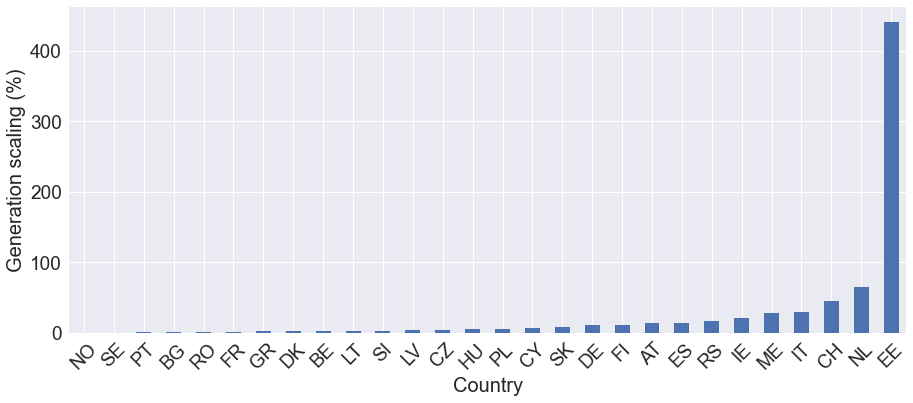

In [196]:
fig, ax = plt.subplots(1, 1)

ax = round(GE_compar, 2).sort_values(by='diff_pro')['diff_pro'].plot(kind='bar', ylabel='Generation scaling (%)')

ax.set_xlabel("Country" , fontsize=20)
ax.set_ylabel("Generation scaling (%)", fontsize=20)

ax.tick_params(axis='y',labelsize=19)
ax.tick_params(axis='x',labelsize=19)


ax.tick_params(axis='x', rotation=45)

In [197]:
fig.savefig(os.path.join(output_directory_path + '/_generation_scaling.png'))

(0.0, 80.0)

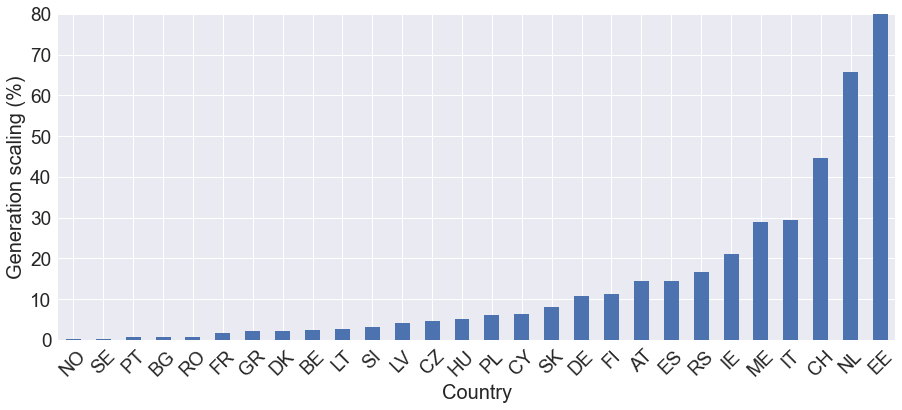

In [198]:
fig, ax = plt.subplots(1, 1)

ax = round(GE_compar, 2).sort_values(by='diff_pro')['diff_pro'].plot(kind='bar', ylabel='Generation scaling (%)')

ax.set_xlabel("Country" , fontsize=20)
ax.set_ylabel("Generation scaling (%)", fontsize=20)

ax.tick_params(axis='y',labelsize=19)
ax.tick_params(axis='x',labelsize=19)


ax.tick_params(axis='x', rotation=45)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(0, 80)  # most of the data

In [199]:
fig.savefig(os.path.join(output_directory_path + '/_generation_scaling_zoom.png'))

# Export datasets

In [31]:
entsoe_gen_type.to_csv(output_directory_path + '/entsoe_gen_type_hourly.csv')

In [32]:
entsoe_gen_type_table.to_csv(output_directory_path + '/entsoe_gen_type_hourly_table.csv')

In [33]:
entso_scaled.to_csv(output_directory_path + '/entso_gen_type_hourly_table_scaled.csv')

# Export tech Dic

In [34]:
dic = {
            'Fossil Hard coal': 'hard_coal', 
            'Fossil Brown coal/Lignite': 'lignite', 
            'Fossil Gas': 'gas',
            'Fossil Coal-derived gas': 'other_fossil',
            'Fossil Peat': 'other_fossil',
            'Nuclear': 'nuclear',
            'Biomass': 'biomass',
            'Waste': 'waste',
            'Geothermal': 'other_renewable',
            'Marine': 'other_renewable',
            'Other': 'other_fossil',
            'Hydro Pumped Storage': 'hydro',
            'Hydro Run-of-river and poundage': 'hydro',
            'Hydro Water Reservoir': 'hydro',
            'Fossil Oil': 'other_fossil',
            'Fossil Oil shale': 'other_fossil', 
            'Solar': 'solar',
            'Wind Onshore': 'wind_onshore',
            'Wind Offshore': 'wind_offshore',
            'Other renewable': 'other_renewable'}

In [35]:
pd.DataFrame.from_dict(dic, columns=['B'], orient='index').to_csv(output_directory_path + '/entso_gen_type_dic.csv')